In [386]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
olympics=0
if olympics==0:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    #create using scikit learn a 2 numerical features dataset with 100 samples from a linear distribution
    from sklearn.datasets import make_regression
    X,Y=make_regression(n_samples=100, n_features=2, noise=0.1)
    dataset=pd.DataFrame({'features':X[:,0],'features2':X[:,1],'targets':Y})
from sklearn.model_selection import train_test_split
dataset_train,dataset_test=train_test_split(dataset,test_size=0.2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


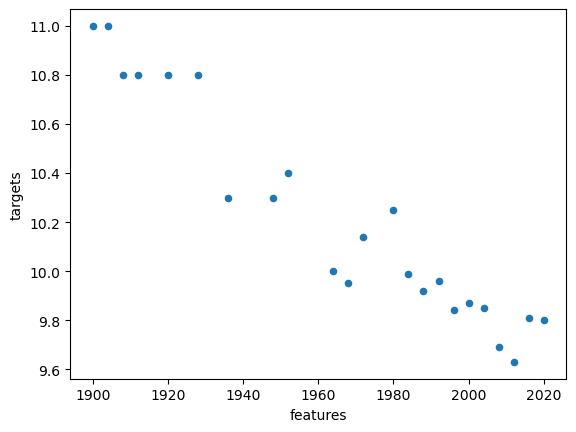

In [387]:
#plot
if dataset_train.shape[1]==2:
    dataset_train.plot.scatter(x='features',y='targets')

In [388]:
#coarse to fine approach
from ridge import Ridge_Regression
X=dataset_train.drop('targets',axis=1).values.reshape(-1,dataset_train.shape[1]-1)
Y=dataset_train['targets'].values.reshape(-1,1)
## given the low amount of data available we decided to do a K-fold cross validation
## the parameter lambda follows a coarse to fine approach
## the coarse search is done with a step of 0.1 and the fine search with a step of 0.01
k=len(X)
fold_size=int(len(X)/k)
lambda_mses=[]
# generate the intervals for the coarse to fine approach from 1 to 10^-20
lambda_values=np.array(10.0 ** np.arange(10, -10, -1))
for lambda_value in lambda_values:
    print('Lambda value: ',lambda_value)
    ridge=Ridge_Regression(lambda_value)
    mses=[]
    for i in range(k):
        # K-fold cross validation (take the data from the i-th fold as test data)
        Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
        Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
        ridge.Train(Xi,Yi)
        y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
        mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
    lambda_mses.append(np.mean(mses))
    print('lambda: ',lambda_value,' mse: ',np.mean(mses))
print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
lambda_value=lambda_values[np.argmin(lambda_mses)]

Lambda value:  10000000000.0
lambda:  10000000000.0  mse:  0.20542527282453044
Lambda value:  1000000000.0
lambda:  1000000000.0  mse:  0.20541471221253432
Lambda value:  100000000.0
lambda:  100000000.0  mse:  0.20530915519171297
Lambda value:  10000000.0
lambda:  10000000.0  mse:  0.20425847446111292
Lambda value:  1000000.0
lambda:  1000000.0  mse:  0.1942209522382913
Lambda value:  100000.0
lambda:  100000.0  mse:  0.12671153124673232
Lambda value:  10000.0
lambda:  10000.0  mse:  0.028838596624062924
Lambda value:  1000.0
lambda:  1000.0  mse:  0.017952398486158195
Lambda value:  100.0
lambda:  100.0  mse:  0.017768793338499
Lambda value:  10.0
lambda:  10.0  mse:  0.01776639987736202
Lambda value:  1.0
lambda:  1.0  mse:  0.017766330632667714
Lambda value:  0.1
lambda:  0.1  mse:  0.017766325420298688
Lambda value:  0.01
lambda:  0.01  mse:  0.017766324916136694
Lambda value:  0.001
lambda:  0.001  mse:  0.01776632486589745
Lambda value:  0.0001
lambda:  0.0001  mse:  0.017766324

In [389]:
order_of_magnitude=lambda_value
for order in np.array(10.0 ** np.arange(np.log10(order_of_magnitude)+1, -10, -1)):
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1*order,0),lambda_values[np.argmin(lambda_mses)]+1*order,num=(20+1))
    lambda_mses=[]
    for lambda_value in lambda_values:
        print('lambda_value: ',lambda_value)
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        for i in range(k):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
            Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
            mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        print('lambda: ',lambda_value,' mse: ',np.mean(lambda_mses))
    print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    lambda_value=lambda_values[np.argmin(lambda_mses)]

print('best lambda: ',lambda_value)

lambda_value:  0.0
lambda:  0.0  mse:  0.017766324860142946
lambda_value:  5.500000000000001e-10
lambda:  5.500000000000001e-10  mse:  0.017766324860142946
lambda_value:  1.1000000000000001e-09
lambda:  1.1000000000000001e-09  mse:  0.017766324860142946
lambda_value:  1.6500000000000003e-09
lambda:  1.6500000000000003e-09  mse:  0.017766324860142946
lambda_value:  2.2000000000000003e-09
lambda:  2.2000000000000003e-09  mse:  0.017766324860142946
lambda_value:  2.7500000000000002e-09
lambda:  2.7500000000000002e-09  mse:  0.017766324860142946
lambda_value:  3.3000000000000006e-09
lambda:  3.3000000000000006e-09  mse:  0.017766324860142946
lambda_value:  3.8500000000000006e-09
lambda:  3.8500000000000006e-09  mse:  0.017766324860142946
lambda_value:  4.4000000000000005e-09
lambda:  4.4000000000000005e-09  mse:  0.017766324860142946
lambda_value:  4.9500000000000005e-09
lambda:  4.9500000000000005e-09  mse:  0.01776632486014295
lambda_value:  5.5000000000000004e-09
lambda:  5.500000000000

In [390]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y) ## train on the training dataset
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
y_pred=ridge.Predict(X_test)
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(X_test)
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',Y_test[i])
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',y_pred[i])
    print('scikit: year: ',X_test[i],' time: ',y_pred_sklearn[i])
    
print('w_mio: ',ridge.__str__())
print('w_sklearn: ',ridge_sklearn.coef_,ridge_sklearn.intercept_)
# mse on the training set
print('mse: ',((Y_test-ridge.Predict(X_test))**2).mean())
print('mse sklearn: ',((Y_test-ridge_sklearn.predict(X_test))**2).mean())

year:  [1932]  time:  [10.32]
year:  [1960]  time:  [10.2]
year:  [1924]  time:  [10.6]
year:  [1956]  time:  [10.5]
year:  [1896]  time:  [12.]
year:  [1976]  time:  [10.06]
year:  [1932]  time:  [10.57797682]
scikit: year:  [1932]  time:  [10.57797682]
year:  [1960]  time:  [10.27511977]
scikit: year:  [1960]  time:  [10.27511977]
year:  [1924]  time:  [10.66450741]
scikit: year:  [1924]  time:  [10.66450741]
year:  [1956]  time:  [10.31838506]
scikit: year:  [1956]  time:  [10.31838506]
year:  [1896]  time:  [10.96736447]
scikit: year:  [1896]  time:  [10.96736447]
year:  [1976]  time:  [10.10205859]
scikit: year:  [1976]  time:  [10.10205859]
w_mio:  ('Ridge Regression model with weights: ', array([[ 3.14751136e+01],
       [-1.08163234e-02]]))
w_sklearn:  [[-0.01081632]] [31.47511363]
mse:  0.19624088060293501
mse sklearn:  0.19624088060203712


C:\Users\miche\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\miche\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\miche\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\miche\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\miche\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not w

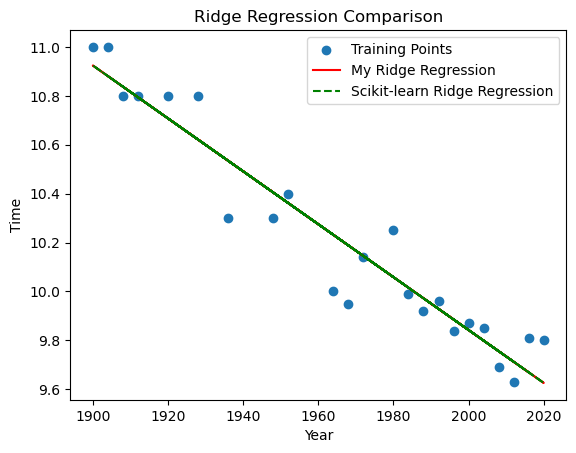

In [391]:
#plot if 1D
if dataset_train.shape[1]==2:
    import matplotlib.pyplot as plt   
    ridge=Ridge_Regression(lambda_value)
    ridge.Train(X,Y)
    y_pred=ridge.Predict(X)
    from sklearn.linear_model import Ridge
    ridge_sklearn=Ridge(alpha=lambda_value)
    ridge_sklearn.fit(X,Y)
    y_pred_sklearn=ridge_sklearn.predict(X)
    from sklearn.linear_model import RidgeCV
    ridge_cv=RidgeCV(cv=k)
    ridge_cv.fit(X,Y)
    y_pred_cv=ridge_cv.predict(X)
    plt.scatter(X, Y, label='Training Points')
    plt.plot(X, y_pred, label='My Ridge Regression', color='red')
    plt.plot(X, y_pred_sklearn, label='Scikit-learn Ridge Regression', linestyle='--', color='green')
    
    plt.title('Ridge Regression Comparison')
    plt.xlabel('Year')
    plt.ylabel('Time')
    plt.legend()
    plt.show()